## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [21]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import seaborn as sns

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
# let's identify the categorical variables
# we will capture those of type *object*

cat_vars = [var for var in data.columns if data[var].dtype == 'O']
#seems pclass is categorical
cat_vars = cat_vars + ['pclass']
# number of categorical variables
len(cat_vars)

5

In [11]:
cat_vars

['sex', 'cabin', 'embarked', 'title', 'pclass']

In [12]:
data[cat_vars] = data[cat_vars].astype('O')

In [13]:
# now let's identify the numerical variables

num_vars = [
    var for var in data.columns if var not in cat_vars and var != 'survived'
]

# number of numerical variables
len(num_vars)

4

In [14]:
vars_num = num_vars

vars_cat = cat_vars

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 4
Number of categorical variables: 5


### Find missing values in variables

In [15]:
# first in numerical variables

# make a list of the variables that contain missing values
vars_with_na = [var for var in vars_num if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_na].isnull().mean().sort_values(ascending=False)

age     0.200917
fare    0.000764
dtype: float64

In [16]:
# now in categorical variables

# make a list of the variables that contain missing values
vars_with_na = [var for var in vars_cat if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_na].isnull().mean().sort_values(ascending=False)

cabin       0.774637
embarked    0.001528
dtype: float64

### Determine cardinality of categorical variables

<AxesSubplot:>

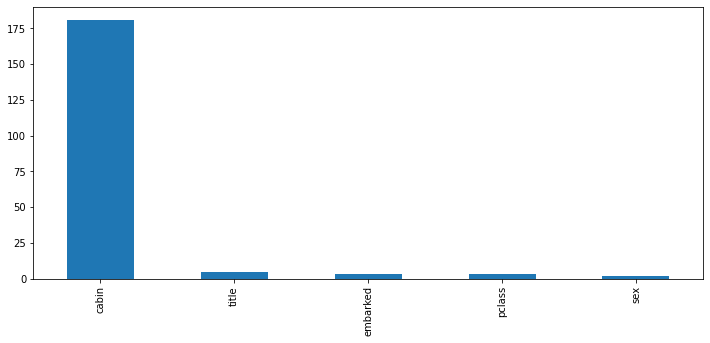

In [17]:
# we count unique categories with pandas unique() 
# and then plot them in descending order

data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Determine the distribution of numerical variables

In [18]:
#  let's male a list of discrete variables
discrete_vars = [var for var in vars_num if len(
    data[var].unique()) < 20 ]


print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  2


In [19]:
# let's visualise the discrete variables

data[discrete_vars].head()

,sibsp,parch
0,0,0
1,1,2
2,1,2
3,1,2
4,1,2


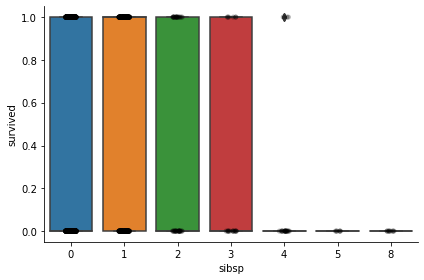

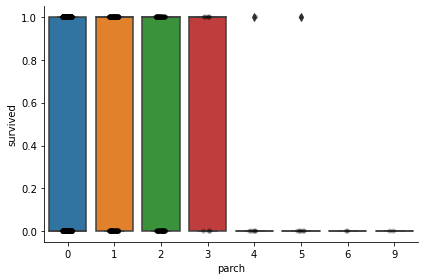

In [22]:
for var in discrete_vars:
    # make boxplot with Catplot
    sns.catplot(x=var, y='survived', data=data, kind="box", height=4, aspect=1.5)
    # add data points to boxplot with stripplot
    sns.stripplot(x=var, y='survived', data=data, jitter=0.1, alpha=0.3, color='k')
    plt.show()

In [23]:
# make list of continuous variables
cont_vars = [
    var for var in vars_num if var not in discrete_vars]

print('Number of continuous variables: ', len(cont_vars))

Number of continuous variables:  2


In [24]:
data[cont_vars].head()

,age,fare
0,29.0000,211.3375
1,0.9167,151.5500
2,2.0000,151.5500
3,30.0000,151.5500
4,25.0000,151.5500


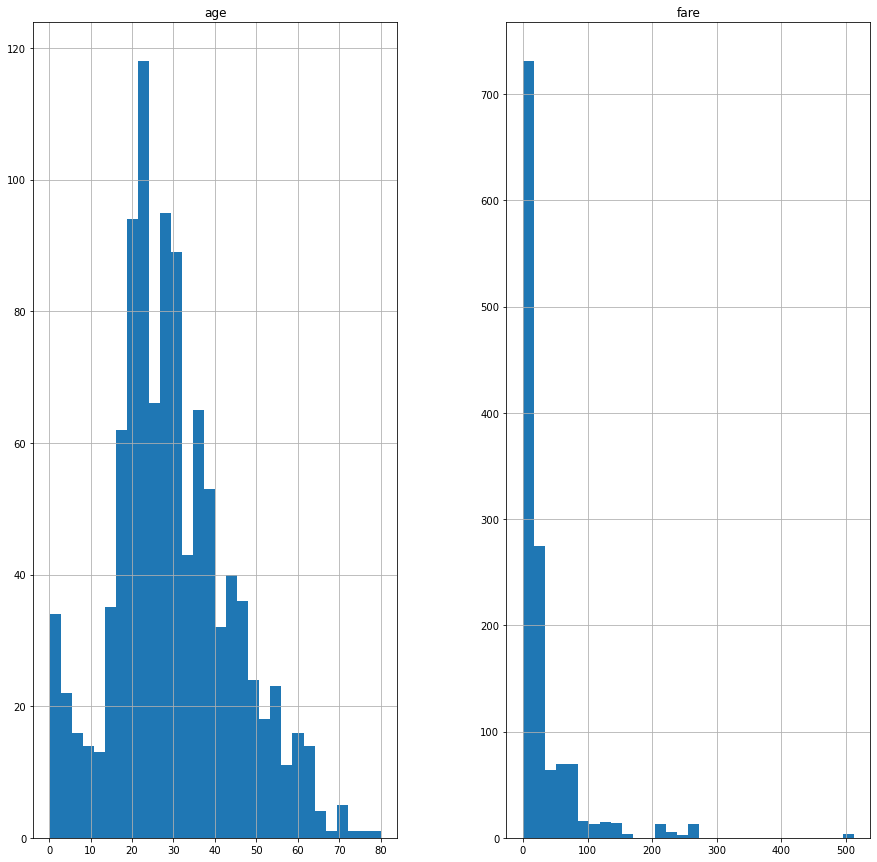

In [25]:
# lets plot histograms for all continuous variables

data[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

In [26]:
# first make a list with the super skewed variables
# for later

skewed = [
    'age'
]

In [27]:
# capture the remaining continuous variables

cont_vars = [
   'fare'
]

### Yeo-Johnson transformation

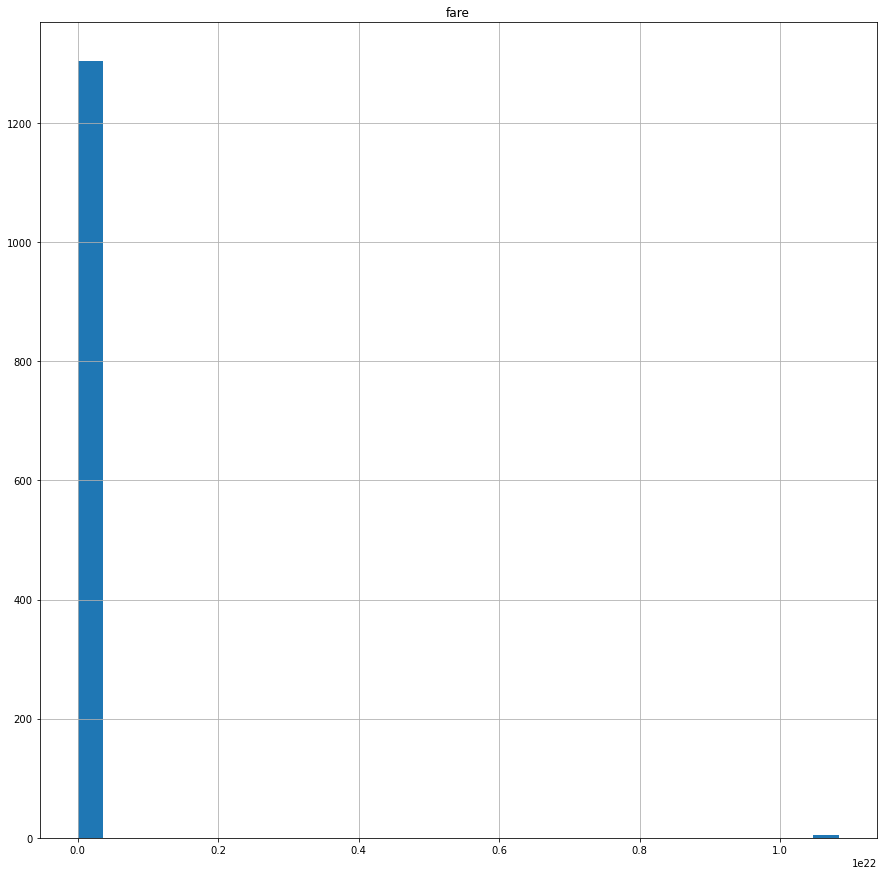

In [28]:
# for the yeo-johnson transformation
import scipy.stats as stats
# Let's go ahead and analyse the distributions of the variables
# after applying a yeo-johnson transformation

# temporary copy of the data
tmp = data.copy()

for var in cont_vars:

    # transform the variable - yeo-johsnon
    tmp[var], param = stats.yeojohnson(data[var])

    
# plot the histograms of the transformed variables
tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

For fare and age the transformation did not do an amazing job. 

For the others, the values seem to be spread more evenly in the range.

Whether this helps improve the predictive power, remains to be seen. To determine if this is the case, we should train a model with the original values and one with the transformed values, and determine model performance, and feature importance. But that escapes the scope of this course.

Here, we will do a quick visual exploration here instead:

/usr/local/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


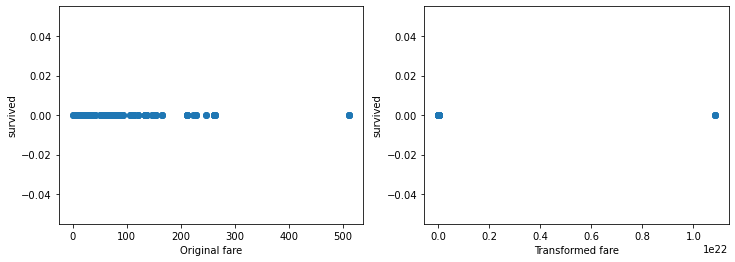

In [29]:
# let's plot the original or transformed variables


for var in cont_vars:
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    plt.scatter(data[var], np.log(data['survived']))
    plt.ylabel('survived')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(tmp['survived']))
    plt.ylabel('survived')
    plt.xlabel('Transformed ' + var)
                
    plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

In [31]:
data

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs
...,...,...,...,...,...,...,...,...,...,...
1304,3,0,female,14.5000,1,0,14.4542,NaN,C,Miss
1305,3,0,female,NaN,1,0,14.4542,NaN,C,Miss
1306,3,0,male,26.5000,0,0,7.2250,NaN,C,Mr
1307,3,0,male,27.0000,0,0,7.2250,NaN,C,Mr


## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [32]:
data['cabin'] = data['cabin'].str.replace('\d+', '')
data['cabin'] = data['cabin'].str.extract('([A-Za-z]+)', expand=False)
print(data['cabin'])

0         B
1         C
2         C
3         C
4         C
       ... 
1304    NaN
1305    NaN
1306    NaN
1307    NaN
1308    NaN
Name: cabin, Length: 1309, dtype: object


/tmp/ipykernel_3068/2133905303.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['cabin'] = data['cabin'].str.replace('\d+', '')


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [33]:
vars_num

['age', 'sibsp', 'parch', 'fare']

In [34]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in vars_num
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

age     0.196753
fare    0.000955
dtype: float64

In [35]:
# replace missing values as we described above

for var in vars_with_na:

    # calculate the median using the train set
    median_val = X_train[var].median()
    
    print(var, median_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the median
    # (in train and test)
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

age 28.0
fare 14.4542


age     0
fare    0
dtype: int64

In [36]:
# check that test set does not contain null values in the engineered variables
[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

In [37]:
X_train[['sex']].head()

,sex
1118,male
44,female
1072,male
1130,female
574,male


### Replace Missing data in categorical variables with the string **Missing**

In [38]:
vars_cat

['sex', 'cabin', 'embarked', 'title', 'pclass']

In [39]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in vars_cat
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

cabin       0.766953
embarked    0.001910
dtype: float64

In [40]:
# replace missing values as we described above

for var in vars_with_na:

    
    X_train[var].fillna("missing", inplace=True)
    X_test[var].fillna("missing", inplace=True)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

cabin       0
embarked    0
dtype: int64

In [41]:
X_train[vars_with_na].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [42]:
data[vars_cat]

,sex,cabin,embarked,title,pclass
0,female,B,S,Miss,1
1,male,C,S,Master,1
2,female,C,S,Miss,1
3,male,C,S,Mr,1
4,female,C,S,Mrs,1
...,...,...,...,...,...
1304,female,NaN,C,Miss,3
1305,female,NaN,C,Miss,3
1306,male,NaN,C,Mr,3
1307,male,NaN,C,Mr,3


In [43]:
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', nan, 'T', 'F', 'G'], dtype=object)

In [45]:
def remove_rare_labels(df, i, rare):
    df = df.copy()
    temp = df.groupby(i)[i].count() / len(df)
    return temp[temp > rare].index

In [46]:
for i in vars_cat:
    rare_labels = remove_rare_labels(X_train, i, 0.05)
    
    #replace rare categories by the string "Rare"
    X_train[i] = np.where(X_train[i].isin(
        rare_labels), X_train[i], 'Rare')
    
    X_test[i] = np.where(X_test[i].isin(
        rare_labels), X_test[i], 'Rare')

In [47]:
X_train[vars_cat].nunique()

sex         2
cabin       2
embarked    4
title       4
pclass      3
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
column_transformer = ColumnTransformer(transformers=[('OHEncode',OneHotEncoder(drop='first'),vars_cat)],remainder='passthrough')
X_train = np.array(column_transformer.fit_transform(X_train))
X_test = np.array(column_transformer.transform(X_test))

In [50]:
X_train

array([[  1.    ,   1.    ,   0.    , ...,   7.925 ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    , ..., 134.5   ,   0.    ,   0.    ],
       [  1.    ,   1.    ,   1.    , ...,   7.7333,   1.    ,   0.    ],
       ...,
       [  0.    ,   1.    ,   1.    , ...,   7.7333,   1.    ,   0.    ],
       [  0.    ,   1.    ,   0.    , ...,  36.75  ,   0.    ,   0.    ],
       [  0.    ,   1.    ,   1.    , ...,  15.5   ,   0.    ,   0.    ]])

In [51]:
X_test

array([[ 1.    ,  1.    ,  0.    , ...,  7.8958,  0.    ,  0.    ],
       [ 0.    ,  1.    ,  0.    , ..., 21.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  0.    , ..., 27.    ,  0.    ,  0.    ],
       ...,
       [ 1.    ,  1.    ,  0.    , ..., 13.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  0.    , ..., 13.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  0.    , ...,  8.05  ,  1.    ,  0.    ]])

### Scale the variables

- Use the standard scaler from Scikit-learn

In [52]:
std_scaler = StandardScaler()

std_scaler.fit(X_train)

X_train = std_scaler.transform(X_train)

X_test = std_scaler.transform(X_test)

In [53]:
X_train

array([[ 0.76104239,  0.55123545, -0.31953914, ..., -0.50478215,
        -0.49492069, -0.03091962],
       [-1.31398725, -1.81410683, -0.31953914, ...,  1.97155505,
        -0.49492069, -0.03091962],
       [ 0.76104239,  0.55123545,  3.12950706, ..., -0.5085326 ,
         2.02052574, -0.03091962],
       ...,
       [-1.31398725,  0.55123545,  3.12950706, ..., -0.5085326 ,
         2.02052574, -0.03091962],
       [-1.31398725,  0.55123545, -0.31953914, ...,  0.05915559,
        -0.49492069, -0.03091962],
       [-1.31398725,  0.55123545,  3.12950706, ..., -0.35658342,
        -0.49492069, -0.03091962]])

In [54]:
X_test

array([[ 0.76104239,  0.55123545, -0.31953914, ..., -0.50535342,
        -0.49492069, -0.03091962],
       [-1.31398725,  0.55123545, -0.31953914, ..., -0.24898038,
        -0.49492069, -0.03091962],
       [ 0.76104239,  0.55123545, -0.31953914, ..., -0.13159525,
        -0.49492069, -0.03091962],
       ...,
       [ 0.76104239,  0.55123545, -0.31953914, ..., -0.40549389,
        -0.49492069, -0.03091962],
       [ 0.76104239,  0.55123545, -0.31953914, ..., -0.40549389,
        -0.49492069, -0.03091962],
       [ 0.76104239,  0.55123545, -0.31953914, ..., -0.50233662,
         2.02052574, -0.03091962]])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [55]:
logistic_reg = LogisticRegression(C=0.0005, random_state=0 )
logistic_reg.fit(X_train, y_train)
y_pred = logistic_reg.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.687
ROC-AUC : 0.590


In [56]:
logistic_reg = LogisticRegression(C=0.0005, solver='liblinear', penalty='l1', random_state=0)
logistic_reg.fit(X_train, y_train)
y_pred = logistic_reg.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.618
ROC-AUC : 0.500


In [57]:
logistic_reg = LogisticRegression(C=0.0005, solver='liblinear', penalty='l2', random_state=0)
logistic_reg.fit(X_train, y_train)
y_pred = logistic_reg.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.782
ROC-AUC : 0.767


In [58]:
logistic_reg =LogisticRegression(C=0.0005, random_state=0,solver='liblinear',penalty='l2')
logistic_reg.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0, solver='liblinear')

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [59]:
y_pred = logistic_reg.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.782
ROC-AUC : 0.767


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**